In [288]:
import numpy as np
from __future__ import print_function

import os, time
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader

class NPZDataset(Dataset):
    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
        """
        self._transform = transform
        self._files = []

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if (flavour is None or flavour in f) and f.endswith('.npz') ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        # Need to know the total number of events. Compute.                                                                                             
        num_events_v = [np.load(f)['labels'].shape[0] for f in self._files]
        length = np.sum(num_events_v)

        # When an event is requested, need to know which file it comes from. Create a file/event index.                                                 
        self._file_index  = np.zeros([length],dtype=np.int32)
        self._event_index = np.zeros([length],dtype=np.int32)
        ctr=0
        for findex,num_events in enumerate(num_events_v):
            self._file_index  [ctr:ctr+num_events] = findex
            self._event_index [ctr:ctr+num_events] = np.arange(num_events)
            ctr += num_events
    
    def __len__(self):
        return len(self._file_index)

    def __getitem__(self,idx):
        # Read data file for the specified index=idx                                                                                                    
        f = np.load(self._files[self._file_index[idx]])
        # Retrieve event index in this file that corresponds to overall index=idx                                                                       
        i = self._event_index[idx]
        # Retrieve data & label                                                                                                                         
        label = f['labels'][i]
        data  = f['event_data'][i]
        # Apply transformation function if necessary                                                                                                    
        if self._transform is not None:
            data = self._transform(data)
        return data,label,idx

def HKCollate(batch):
    data  = np.vstack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

# Data directories: let's use e- and mu-
DATA_DIRS = ['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']
# Craete an instance
ds = NPZDataset(DATA_DIRS,flavour='.npz')
print(len(ds),'total events are loaded!')

3300000 total events are loaded!


Entry 5 ... label: 1 ... data shape: (88, 168, 2)


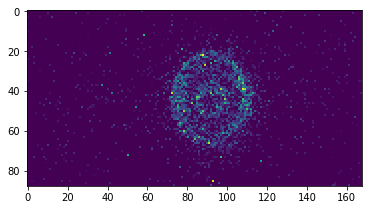

In [289]:
# Access index 5
ENTRY=5
data,label,idx = ds[ENTRY]

# Data shape
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)

# Visualize
plt.imshow(data[:,:,0])
plt.show()

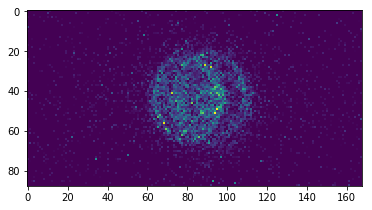

In [290]:
# create multi-ring?

plt.imshow(ds[5][0][:,:,0] + ds[6][0][:,:,0])
plt.show()

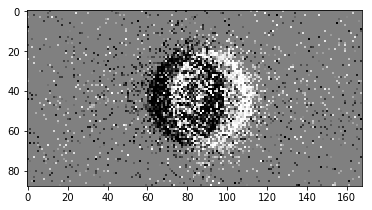

In [301]:
plt.imshow(np.exp(ds[5][0][:,:,0]) / (np.exp(ds[5][0][:,:,0]) + np.exp(ds[6][0][:,:,0])), cmap='gray')
plt.show()

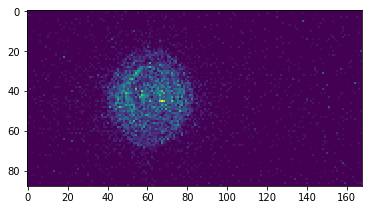

In [291]:
plt.imshow(ds[7][0][:,:,0] + ds[8][0][:,:,0])
plt.show()

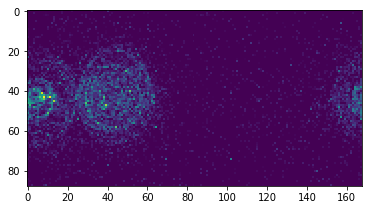

In [292]:
plt.imshow(ds[9][0][:,:,0] + ds[10][0][:,:,0])
plt.show()

In [4]:
loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 5
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )

In [5]:
import h5py
# Open a file
f = h5py.File('/data/hkml_data/IWCDgrid/varyE/e-/IWCDgrid_varyE_e-_R0cm_20-2000MeV_100k.h5', mode='r')
# List keys
for key in f.keys():
    print('%s ... Shape %s' % (key, str(f[key].shape)))

directions ... Shape (100000, 1, 3)
energies ... Shape (100000, 1)
event_data ... Shape (100000, 88, 168, 2)
labels ... Shape (100000,)
pids ... Shape (100000, 1)
positions ... Shape (100000, 1, 3)


In [6]:
import h5py

class H5Dataset(Dataset):

    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename. or None                                                                    
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        return fh['event_data'][entry_index],fh['labels'][entry_index],idx

In [7]:
ds = H5Dataset(DATA_DIRS,flavour='100k.h5')
print(len(ds),'total events are loaded!')
# Access an index

300000 total events are loaded!


Entry 5 ... label: 1.0 ... data shape: (88, 168, 2)


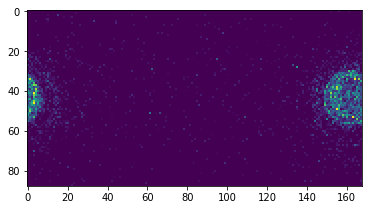

In [8]:
data,label,idx = ds[ENTRY]
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
plt.imshow(data[:,:,0])
plt.show()

Entry 6 ... label: 1.0 ... data shape: (88, 168, 2)


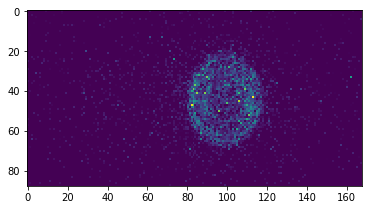

In [10]:
ENTRY=6

data,label,idx = ds[ENTRY]
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
plt.imshow(data[:,:,0])
plt.show()

Entry 7 ... label: 1.0 ... data shape: (88, 168, 2)


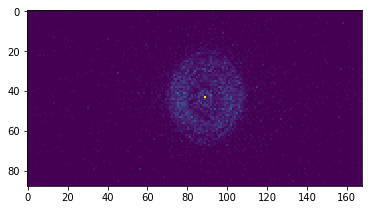

In [11]:
ENTRY=7

data,label,idx = ds[ENTRY]
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
plt.imshow(data[:,:,0])
plt.show()

Entry 8 ... label: 1.0 ... data shape: (88, 168, 2)


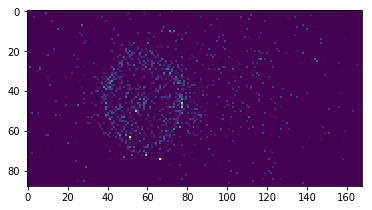

In [13]:
ENTRY=8

data,label,idx = ds[ENTRY]
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
plt.imshow(data[:,:,0])
plt.show()

notice that we loaded all PIDs, but at the H5Dataset level things are sequential, so we will see the same PID again and again.

In [14]:
loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 5
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )

In [15]:
def loop(loader,loop_limit=3):

    # Let's measure time that takes in each loop
    trecord = np.zeros([loop_limit],dtype=np.float32)
    t = time.time()
    for iteration, batch in enumerate(loader):
        data,label,index = batch

        # Print out some content info
        print('Iteration',iteration,'... time:',time.time()-t,'[s]')
        print('    Labels:',label)
        print('    Index :',index,'\n')
        trecord[iteration] = time.time() - t
        t = time.time()

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return trecord

In [16]:
time_record = loop(loader,5)
print('Overall average iteration time:',time_record.mean(),'[s]')
print('First event     iteration time:',time_record[0],    '[s]')
print('After first event average time:',time_record[1:].mean(),'[s]')

Iteration 0 ... time: 0.132498025894 [s]
    Labels: [2.0, 0.0, 1.0, 0.0, 2.0]
    Index : [171674, 235264, 52642, 216930, 133614] 

Iteration 1 ... time: 0.000733137130737 [s]
    Labels: [0.0, 0.0, 2.0, 0.0, 0.0]
    Index : [259576, 277368, 167030, 235429, 231749] 

Iteration 2 ... time: 0.0395591259003 [s]
    Labels: [2.0, 1.0, 2.0, 1.0, 1.0]
    Index : [120583, 73251, 179297, 11181, 85111] 

Iteration 3 ... time: 0.00078010559082 [s]
    Labels: [2.0, 2.0, 2.0, 2.0, 2.0]
    Index : [197991, 111148, 157213, 170143, 135466] 

Iteration 4 ... time: 0.0320119857788 [s]
    Labels: [2.0, 1.0, 1.0, 0.0, 1.0]
    Index : [110447, 26334, 10687, 254573, 67978] 

Overall average iteration time: 0.04233227 [s]
First event     iteration time: 0.13455606 [s]
After first event average time: 0.019276321 [s]


In [28]:
for iteration, batch in enumerate(loader):
    data,label,index = batch
    print(data.shape)
    break

(440, 168, 2)


In [27]:
data.shape

(440, 168, 2)

Notice that before we had `(88,168,2)` which is combined in `HKCollate` via `np.vstack`. I think we need to modify this to add more dimension.

In [37]:
print(np.vstack([data,data]).shape)
print(np.hstack([data,data]).shape)
print(np.stack([data,data]).shape)

(880, 168, 2)
(440, 336, 2)
(2, 440, 168, 2)


In [41]:
def HKCollate(batch):
    data  = np.stack([sample[0] for sample in batch])
    label = [sample[1] for sample in batch]
    idx   = [sample[2] for sample in batch]
    return data,label,idx

loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 5
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )

for iteration, batch in enumerate(loader):
    data,label,index = batch
    print(data.shape)
    print(data[0].shape)
    break

(5, 88, 168, 2)
(88, 168, 2)


Entry 0 ... label: 1.0 ... data shape: (88, 168, 2)


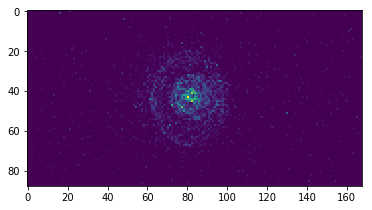

In [42]:
ENTRY=0

print('Entry',ENTRY,'... label:',label[ENTRY],'... data shape:',data[ENTRY].shape)
plt.imshow(data[ENTRY][:,:,0])
plt.show()

Entry 1 ... label: 2.0 ... data shape: (88, 168, 2)


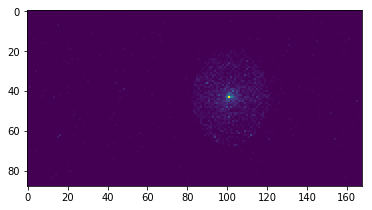

In [43]:
ENTRY=1

print('Entry',ENTRY,'... label:',label[ENTRY],'... data shape:',data[ENTRY].shape)
plt.imshow(data[ENTRY][:,:,0])
plt.show()

Entry 2 ... label: 1.0 ... data shape: (88, 168, 2)


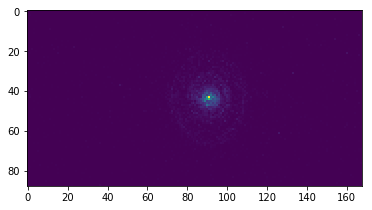

In [44]:
ENTRY=2

print('Entry',ENTRY,'... label:',label[ENTRY],'... data shape:',data[ENTRY].shape)
plt.imshow(data[ENTRY][:,:,0])
plt.show()

Entry 3 ... label: 0.0 ... data shape: (88, 168, 2)


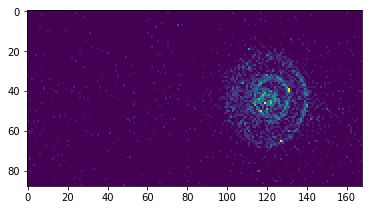

In [45]:
ENTRY=3

print('Entry',ENTRY,'... label:',label[ENTRY],'... data shape:',data[ENTRY].shape)
plt.imshow(data[ENTRY][:,:,0])
plt.show()

Entry 4 ... label: 1.0 ... data shape: (88, 168, 2)


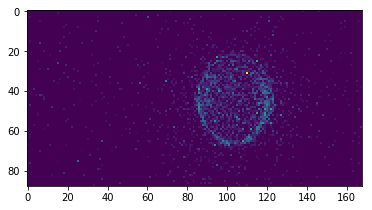

In [46]:
ENTRY=4

print('Entry',ENTRY,'... label:',label[ENTRY],'... data shape:',data[ENTRY].shape)
plt.imshow(data[ENTRY][:,:,0])
plt.show()

let's try to plot total charge vs. energy for each category

In [53]:
import h5py

class H5Dataset(Dataset):

    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename. or None                                                                    
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        return {
            'event_data': fh['event_data'][entry_index],
            'labels':     fh['labels'][entry_index],
            'indices':    idx,
            'pids':       fh['pids'][entry_index],
            'energies':   fh['energies'][entry_index],
            'positions':  fh['positions'][entry_index],
            'directions': fh['directions'][entry_index],
        }

def HKCollate(batch):
    ret = {}
    for key in batch[0].keys():
        ret[key] = [sample[key] for sample in batch]
    ret['event_data'] = np.stack(ret['event_data'])
    return ret

ds = H5Dataset(DATA_DIRS,flavour='100k.h5')
print(len(ds),'total events are loaded!')

loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 5
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )

for iteration, batch in enumerate(loader):
    print(batch['event_data'].shape)
    print(batch['event_data'][0].shape)
    print(batch['energies'])
    break

300000 total events are loaded!
(5, 88, 168, 2)
(88, 168, 2)
[array([1072.42], dtype=float32), array([ 70.5039, 720.454 ], dtype=float32), array([1704.2188], dtype=float32), array([1938.5223], dtype=float32), array([1224.6852], dtype=float32)]


the labels are:

>  The type of particle (0 for gamma, 1 for e-, 2 for mu-, 3 for pi0) being simulated, shape (N,).

PID is

> The PDG code of each particle simulated, shape (N, P). P is 1 for e-, mu- and pi0 but 2 for gamma (because gammas are simulated as an electron-positron pair).

same with energy etc.

> The energies of each particle simulated, shape (N, P).

it's a bit annoying when the width of the energy array differs every time, so let's just use e- and mu- only, so we don't need to think about gammas etc..

Or, since in some sense the parent particle had the sum of energies, we can sum the values to get the original. For position let's simply take the mean (not really correct, better would be to find the intersection of the direction vectors). The direction we can use simply the weighted average with energy.

In [95]:
import h5py

class H5Dataset(Dataset):

    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename. or None                                                                    
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        
        ret = {
            'event_data': fh['event_data'][entry_index],
            'labels':     fh['labels'][entry_index],
            'indices':    idx,
            'pids':       fh['pids'][entry_index],
            'energies':   fh['energies'][entry_index],
            'positions':  fh['positions'][entry_index],
            'directions': fh['directions'][entry_index],
        }
        
        if (len(ret['pids']) == 2):
            # 0 specifies axis
            ret['directions'] = (ret['positions'].T * ret['energies']).T.sum(0)/ret['energies'].sum()
            
            ret['pids'] = ret['pids'].sum() # gives me 0 because e-:11, e+:-11
            ret['energies'] = ret['energies'].sum()
            ret['positions'] = ret['positions'].sum(0) # 0 specifies axis
        
        return ret

def HKCollate(batch):
    ret = {}
    for key in batch[0].keys():
        ret[key] = [sample[key] for sample in batch]
    for key in ['event_data','pids','energies','positions','directions']:
        ret[key] = np.stack(ret[key])
    return ret

DATA_DIRS = ['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-']
ds = H5Dataset(DATA_DIRS,flavour='100k.h5')
print(len(ds),'total events are loaded!')

loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 5
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )

for iteration, batch in enumerate(loader):
    print(batch['event_data'].shape)
    print(batch['event_data'][0].shape)
    print(batch['energies'])
    break

200000 total events are loaded!
(5, 88, 168, 2)
(88, 168, 2)
[[ 478.0194 ]
 [ 996.18024]
 [1404.3884 ]
 [ 308.45703]
 [1205.6052 ]]


In [96]:
# from before updating the previous to summing the directions etc.
batch['directions'][1].sum(0)

array([-1.6431071e-01, -3.6732051e-06, -9.8640865e-01], dtype=float32)

In [98]:
# previously we had
# array([ 11., -11.], dtype=float32)
batch['pids'][1]

array([11.], dtype=float32)

In [90]:
# this fails because it's (2,3) x (2,)
#batch['directions'][1] * batch['energies'][1]
#batch['directions'][1] * np.array([1.,0.])
# reason is that broadcasting attempts to add 1,... to match tensor rank
# (2,3) x (2,)  ->   (2,3) x (1,2) error

# this should work
print((batch['directions'][1].T * batch['energies'][1]).T)
print((batch['directions'][1].T * np.array([1.,0.])).T)

[[-6.53609772e+01  1.18227955e-02  2.64337387e+01]
 [-6.67277527e+02 -1.47281755e-02  2.71651611e+02]]
[[-9.27054763e-01  1.67689956e-04  3.74925911e-01]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00]]


In [100]:
loader.batch_size

5

In [106]:
np.zeros([3,2])

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [116]:
np.ones([3,2,2]).sum((0,1,2))

12.0

In [146]:
def getTotalCharge(loader,loop_limit=100):
    B = loader.batch_size
    chg    = np.zeros(loop_limit*B)
    energy = np.zeros(loop_limit*B)
    labels = np.zeros(loop_limit*B)
    print(energy[0:5].shape)
    
    for iteration, batch in enumerate(loader):
        idx = np.arange(iteration*B,(iteration+1)*B)
        if iteration == 0:
            print(chg[idx])
            print(batch['event_data'].shape)
            print('event_data.sum((1,2,3)).shape', batch['event_data'].sum((1,2,3)).shape)
            print('energies shape:',batch['energies'].shape)
            print('energies.reshape(-1) shape:',batch['energies'].reshape(-1).shape)
        chg[idx] = batch['event_data'].sum((1,2,3))
        energy[idx] = batch['energies'].reshape(-1)
        labels[idx] = batch['labels']

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return { 'charges': chg, 'energies': energy, 'labels': labels }

QE = getTotalCharge(loader)

(5,)
[0. 0. 0. 0. 0.]
(5, 88, 168, 2)
event_data.sum((1,2,3)).shape (5,)
energies shape: (5, 1)
energies.reshape(-1) shape: (5,)


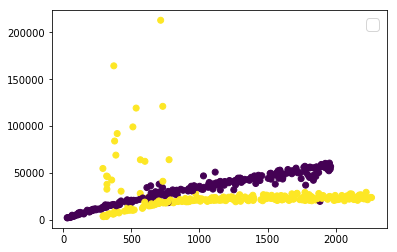

In [149]:
plt.scatter(QE['energies'], QE['charges'], c=QE['labels'])

leg=plt.legend(fontsize=16,loc=1)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.show()

In [162]:
QE['energies'][np.where(QE['labels'][0:10] == 1)]

array([1522.01037598,  106.20546722, 1098.640625  , 1096.02209473,
        499.90066528])

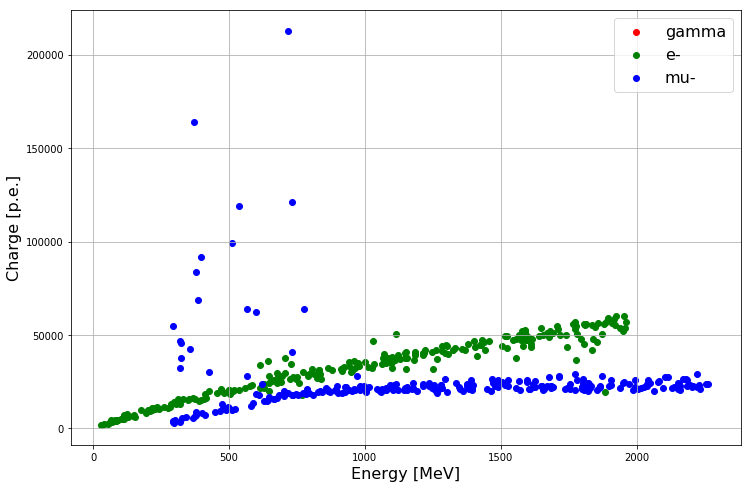

In [166]:
fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
labname = ["gamma","e-","mu-"]
colors = ["red","green","blue"]

for lab in [0,1,2]:
    idx = np.where(QE['labels'] == lab)
    ax.scatter(QE['energies'][idx], QE['charges'][idx], c=colors[lab], label=labname[lab])

ax.set_xlabel('Energy [MeV]',  fontsize=16)
ax.set_ylabel('Charge [p.e.]', fontsize=16)
#ax.tick_params('x',labelsize=20)
#ax.tick_params('y',labelsize=20)
ax.grid()

leg=plt.legend(fontsize=16,loc=1)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.show()

In [189]:
(QE['charges'] > 1e5).nonzero()[0]

array([101, 221, 266, 280])

In [179]:
np.array([])

array([], dtype=float64)

In [194]:
showidx = np.where(QE['charges'] > 1e5)[0]
maxit = QE['charges'].size/loader.batch_size

for iteration, batch in enumerate(loader):
    #print(np.in1d(batch['indices'], showidx))
    bchidx = np.where(np.in1d(batch['indices'], showidx))[0]
    #print(bchidx)
    #print(bchidx.size)
    if bchidx.size > 0:
        print(batch['event_data'].shape)
    
    if iteration+1 >= maxit:
        break
    #break

In [195]:
np.where(QE['charges'] > 1e5)[0]

array([101, 221, 266, 280])

In [204]:
print(np.in1d([101, 3, 221, 266, 280], showidx))
print(np.where(np.in1d([101, 3, 221, 266, 280], showidx))[0])
print(np.where(np.in1d([101, 3, 221, 266, 280], showidx))[0].size)

[ True False  True  True  True]
[0 2 3 4]
4


ah maybe the original indices in showidx is just counting from the start

Idx 101 ... Label 2.0 ... Energy [1049.2297] ... Charge 5414.521


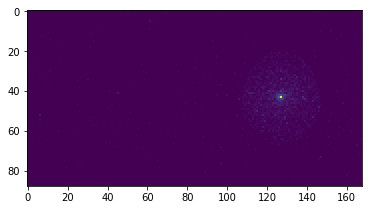

Idx 221 ... Label 2.0 ... Energy [1689.5571] ... Charge 6812.1875


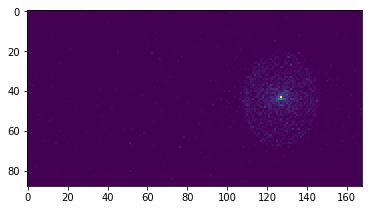

Idx 266 ... Label 2.0 ... Energy [1855.019] ... Charge 5679.038


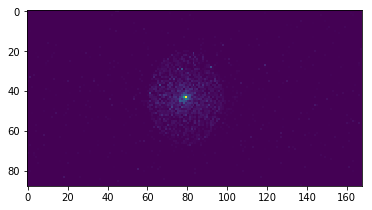

Idx 280 ... Label 1.0 ... Energy [1483.937] ... Charge 12371.205


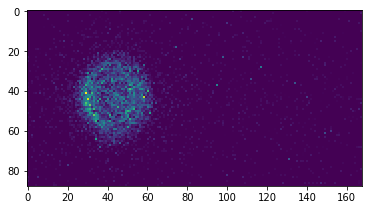

In [212]:
showidx = np.where(QE['charges'] > 1e5)[0]
maxit = QE['charges'].size/loader.batch_size

offset = 0

for iteration, batch in enumerate(loader):
    #print(np.in1d(batch['indices'], showidx))
    bchidx = np.arange(offset, offset+len(batch['indices']))
    bchidx = np.where(np.in1d(bchidx, showidx))[0]
    #print(bchidx)
    #print(bchidx.size)
    for il in bchidx:
        chg = batch['event_data'][il][:,:,0].sum()
        print('Idx', offset+il, '... Label', batch['labels'][il], '... Energy', batch['energies'][il], '... Charge', chg)
        plt.imshow(batch['event_data'][il][:,:,0])
        plt.show()
    
    if iteration+1 >= maxit:
        break
    
    offset += len(batch['indices'])
    #break

I think the issue was before I accidentally included the time in the total charge computation.

In [216]:
def getTotalCharge(loader,loop_limit=100):
    B = loader.batch_size
    chg    = np.zeros(loop_limit*B)
    energy = np.zeros(loop_limit*B)
    labels = np.zeros(loop_limit*B)
    print(energy[0:5].shape)
    
    for iteration, batch in enumerate(loader):
        idx = np.arange(iteration*B,(iteration+1)*B)
        if iteration == 0:
            print(chg[idx])
            print(batch['event_data'].shape)
            print('event_data.sum((1,2)).shape', batch['event_data'][:,:,:,0].sum((1,2)).shape)
            print('energies shape:',batch['energies'].shape)
            print('energies.reshape(-1) shape:',batch['energies'].reshape(-1).shape)
        chg[idx] = batch['event_data'][:,:,:,0].sum((1,2))
        energy[idx] = batch['energies'].reshape(-1)
        labels[idx] = batch['labels']

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return { 'charges': chg, 'energies': energy, 'labels': labels }

QE = getTotalCharge(loader)

(5,)
[0. 0. 0. 0. 0.]
(5, 88, 168, 2)
event_data.sum((1,2)).shape (5,)
energies shape: (5, 1)
energies.reshape(-1) shape: (5,)


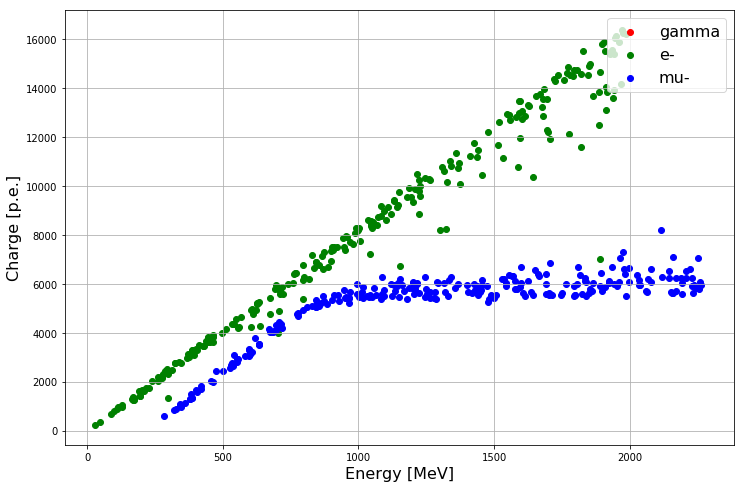

In [217]:
fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
labname = ["gamma","e-","mu-"]
colors = ["red","green","blue"]

for lab in [0,1,2]:
    idx = np.where(QE['labels'] == lab)
    ax.scatter(QE['energies'][idx], QE['charges'][idx], c=colors[lab], label=labname[lab])

ax.set_xlabel('Energy [MeV]',  fontsize=16)
ax.set_ylabel('Charge [p.e.]', fontsize=16)
#ax.tick_params('x',labelsize=20)
#ax.tick_params('y',labelsize=20)
ax.grid()

leg=plt.legend(fontsize=16,loc=1)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.show()

boom! I think the muons saturate because they leave the tank. Let's also load the gammas. Also it seems that I need to redo the `H5Dataset` because it didn't actually work correctly for pi0 (different array shape)

In [273]:
print(1.)
print(np.array(1.))
print([1.])
print(np.array([1.]))
print([[1.]])
print(np.array([[1.]]))

#print(np.array(np.array([1.])))

1.0
1.0
[1.0]
[1.]
[[1.0]]
[[1.]]


In [279]:
print(np.array(ds[290000]['energies'].sum()))
print(np.array(ds[290000]['energies'].sum()))

1456.895
1456.895


In [284]:
print("gamma")
print('label',     ds[290000]['labels'])
print('pid',       ds[290000]['pids'])
print('energy',    ds[290000]['energies'])
print('position',  ds[290000]['positions'])
print('direction', ds[290000]['directions'])

gamma
label 0.0
pid [0.]
energy [1456.895]
position [0. 0. 0.]
direction [0. 0. 0.]


In [283]:
print("electron")
print('label',     ds[0]['labels'])
print('pid',       ds[0]['pids'])
print('energy',    ds[0]['energies'])
print('position',  ds[0]['positions'])
print('direction', ds[0]['directions'])

electron
label 1.0
pid [11.]
energy [1866.9913]
position [[0. 0. 0.]]
direction [[-8.6857694e-01 -3.6732051e-06  4.9555436e-01]]


In [286]:
import h5py

class H5Dataset(Dataset):

    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename. or None                                                                    
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        
        ret = {
            'event_data': fh['event_data'][entry_index],
            'labels':     fh['labels'][entry_index],
            'indices':    idx,
            'pids':       fh['pids'][entry_index],
            'energies':   fh['energies'][entry_index],
            'positions':  fh['positions'][entry_index],
            'directions': fh['directions'][entry_index],
        }
        
        if (len(ret['pids']) == 2):
            # 0 specifies axis
            ret['directions'] = np.array([(ret['positions'].T * ret['energies']).T.sum(0)/ret['energies'].sum()])
            
            ret['pids'] = np.array([ret['pids'].sum()]) # gives me 0 because e-:11, e+:-11
            ret['energies'] = np.array([ret['energies'].sum()])
            ret['positions'] = np.array([ret['positions'].sum(0)]) # 0 specifies axis
        
        return ret

def HKCollate(batch):
    ret = {}
    #print(batch)
    for key in batch[0].keys():
        ret[key] = [sample[key] for sample in batch]
    for key in ['event_data','pids','energies','positions','directions']:
        #print(key)
        ret[key] = np.stack(ret[key])
    return ret

def getTotalCharge(loader,loop_limit=100):
    B = loader.batch_size
    chg    = np.zeros(loop_limit*B)
    energy = np.zeros(loop_limit*B)
    labels = np.zeros(loop_limit*B)
    #print(energy[0:5].shape)
    
    for iteration, batch in enumerate(loader):
        idx = np.arange(iteration*B,(iteration+1)*B)
        if iteration == 0:
            print(chg[idx])
            print(batch['event_data'].shape)
            print('event_data.sum((1,2)).shape', batch['event_data'][:,:,:,0].sum((1,2)).shape)
            print('energies shape:',batch['energies'].shape)
            print('energies.reshape(-1) shape:',batch['energies'].reshape(-1).shape)
        chg[idx] = batch['event_data'][:,:,:,0].sum((1,2))
        energy[idx] = batch['energies'].reshape(-1)
        labels[idx] = batch['labels']

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return { 'charges': chg, 'energies': energy, 'labels': labels }





DATA_DIRS = ['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']
#DATA_DIRS = ['/data/hkml_data/IWCDgrid/varyE/gamma']
ds = H5Dataset(DATA_DIRS,flavour='100k.h5')
print(len(ds),'total events are loaded!')

loader = DataLoader(ds,
                    batch_size=5, # set the batch size = 5
                    shuffle=True,  # enable randomization of samples in a batch
                    num_workers=1, # number of workers to parallelize data streaming
                    collate_fn=HKCollate # collation method
                   )

QE = getTotalCharge(loader)

300000 total events are loaded!
[0. 0. 0. 0. 0.]
(5, 88, 168, 2)
event_data.sum((1,2)).shape (5,)
energies shape: (5, 1)
energies.reshape(-1) shape: (5,)


In [228]:
DATA_DIRS = ['/data/hkml_data/IWCDgrid/varyE/e-']
ds = H5Dataset(DATA_DIRS,flavour='100k.h5')
print(len(ds),'total events are loaded!')

100000 total events are loaded!


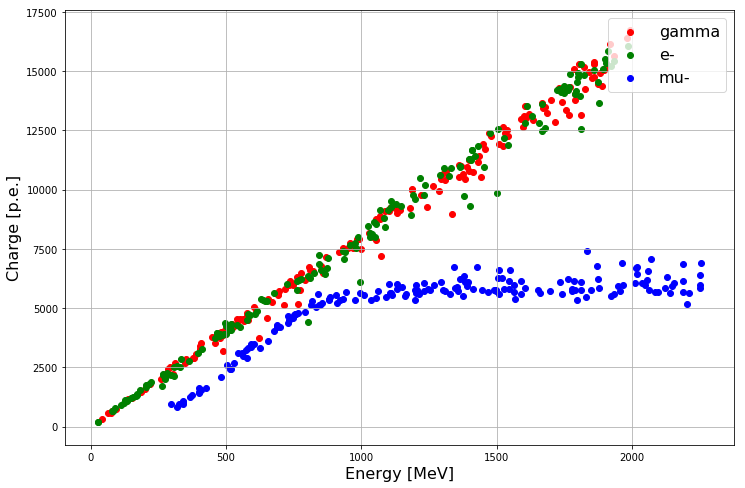

In [287]:
fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
labname = ["gamma","e-","mu-"]
colors = ["red","green","blue"]

for lab in [0,1,2]:
    idx = np.where(QE['labels'] == lab)
    ax.scatter(QE['energies'][idx], QE['charges'][idx], c=colors[lab], label=labname[lab])

ax.set_xlabel('Energy [MeV]',  fontsize=16)
ax.set_ylabel('Charge [p.e.]', fontsize=16)
#ax.tick_params('x',labelsize=20)
#ax.tick_params('y',labelsize=20)
ax.grid()

leg=plt.legend(fontsize=16,loc=1)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.show()